In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import itertools as it

In [2]:
# Download data for chosen stocks
stock_1 = 'HINDALCO.NS'
stock_2 = 'TATASTEEL.NS'
data_1 = yf.download(stock_1, '2022-06-29', '2023-06-29')
data_2 = yf.download(stock_2, '2022-06-29', '2023-06-29')

# Create a new table with closing prices, closing values and daily returns on the stocks chosen
data = pd.DataFrame({
    'HINDALCO': data_1['Close'], 
    'H_Closing': data_1['Close'].diff(), 
    'H_DailyRet': data_1['Close'].pct_change() * 100, 
    'TATASTEEL': data_2['Close'], 
    'T_Closing': data_2['Close'].diff(), 
    'T_DailyRet': data_2['Close'].pct_change() * 100
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


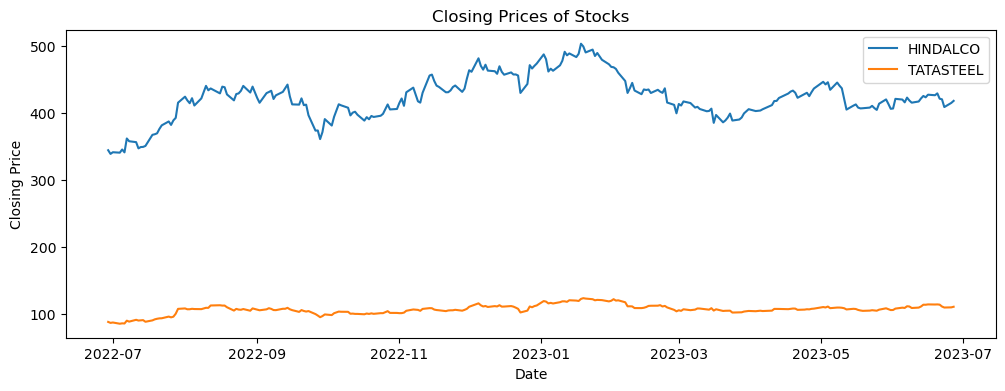

In [3]:
# Plotting closing prices of the stocks chosen
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['HINDALCO'], label='HINDALCO')
plt.plot(data.index, data['TATASTEEL'], label='TATASTEEL')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.title('Closing Prices of Stocks')
plt.show()

In [4]:
# Spread is difference between closing values of the stocks
data['Spread'] = data['H_Closing'] - data['T_Closing']

# Differential is difference between closing prices of the stocks
data['Differential'] = data['HINDALCO'] - data['TATASTEEL']

# Price Ratio is the ratio of the closing prices of the stocks
data['Price_Ratio'] = data['HINDALCO'] / data['TATASTEEL']

In [5]:
# Correlation coefficient using daily returns
Correlation = np.corrcoef(data['H_DailyRet'].tail(246), data['T_DailyRet'].tail(246))[1, 0]
print('Correlation between HINDALCO and TATASTEEL using daily returns:', Correlation)

Correlation between HINDALCO and TATASTEEL using daily returns: 0.7647884797470316


In [6]:
# Calculate the z-score
mean = np.mean(data['Price_Ratio'])
std = np.std(data['Price_Ratio'])
data['z-score'] = (data['Price_Ratio'] - mean) / std

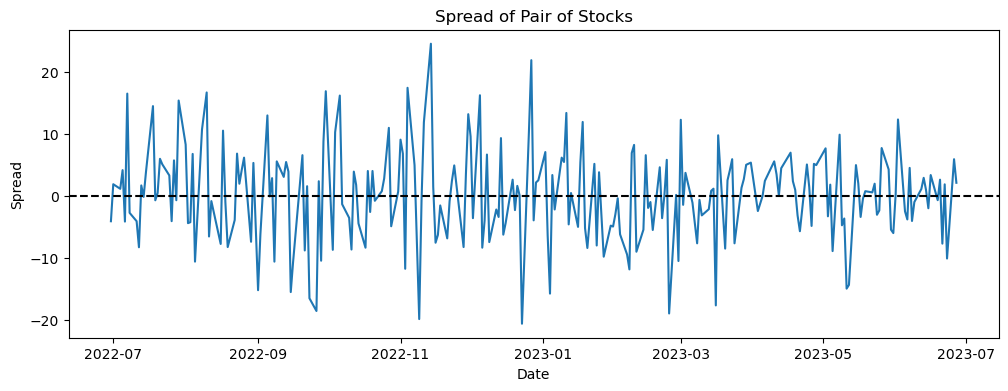

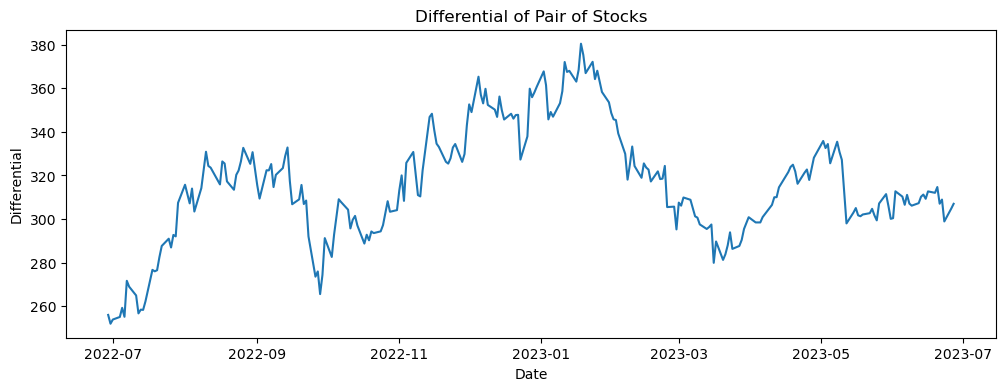

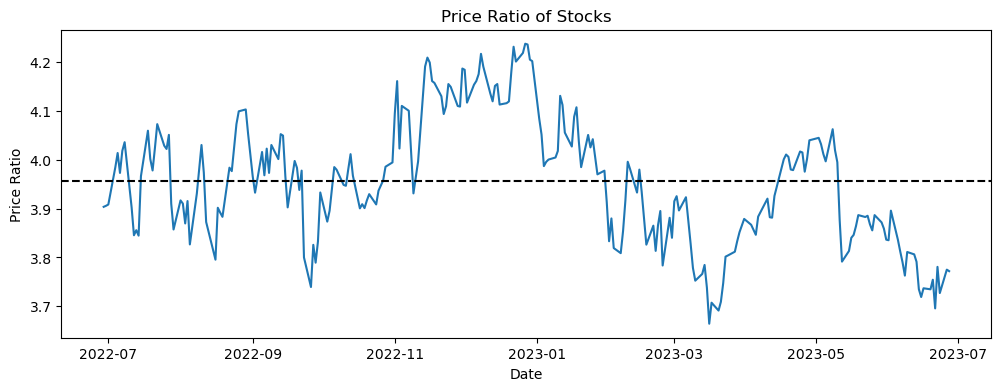

In [7]:
# Plotting the spread, differential and price ratio of the stocks
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Spread'])
plt.axhline(0, linestyle='dashed', color='black')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread of Pair of Stocks')
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Differential'])
plt.xlabel('Date')
plt.ylabel('Differential')
plt.title('Differential of Pair of Stocks')
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Price_Ratio'])
plt.axhline(mean, linestyle='dashed', color='black')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.title('Price Ratio of Stocks')
plt.show()

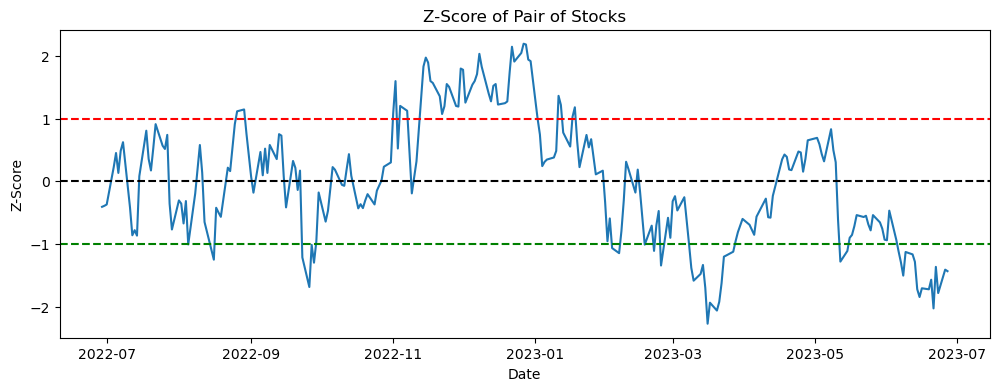

In [8]:
# Plotting the z-score of the stocks
plt.figure(figsize=(12,4))
plt.plot(data.index, data['z-score'])
plt.axhline(1, linestyle='dashed', color='red')
plt.axhline(0, linestyle='dashed', color='black')
plt.axhline(-1, linestyle='dashed', color='green')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score of Pair of Stocks')
plt.show()

In [9]:
# Developig the entry/exit rules and buy/sell signals
lookback_period = 14 
entry_threshold = 1.5 
exit_threshold = 0.7

Spread_Mean = data['Spread'].rolling(window=lookback_period).mean()
Spread_Std = data['Spread'].rolling(window=lookback_period).std()

# Iterate over the spread data
data['Position'] = 0  # 1: long HINDALCO, short TATASTEEL = Buy | -1: short HINDALCO, long TATASTEEL = Sell | 0: no position
data['Action'] = 'No action'
Entry_Price = 0

# Check if the spread crosses the entry threshold in the desired direction
data.loc[(data['Spread'] < (Spread_Mean - (entry_threshold * Spread_Std))) & (data['z-score'] < -0.5) & (data['Position'] == 0), 'Position'] = 1  # Enter long position: long HINDALCO, short TATASTEEL
data.loc[(data['Spread'] > (Spread_Mean + (exit_threshold * Spread_Std))) & (data['z-score'] > 0.5) & (data['Position'] == 0), 'Position'] = -1 # Enter short position: short HINDALCO, long TATASTEEL
Entry_Price = data.query('Position != 0')['Differential'][0]

# Perform trading actions based on the position
data.loc[data['Position'] == 1, 'Action'] = 'Long Hindalco, Short TataSteel'  # Take action for long position: buy HINDALCO, short TATASTEEL
data.loc[data['Position'] == -1, 'Action'] = 'Short Hindalco, Long TataSteel'  # Take action for short position: short HINDALCO, buy TATASTEEL

print('Entry Price =', Entry_Price)

Entry Price = 292.7099914550781


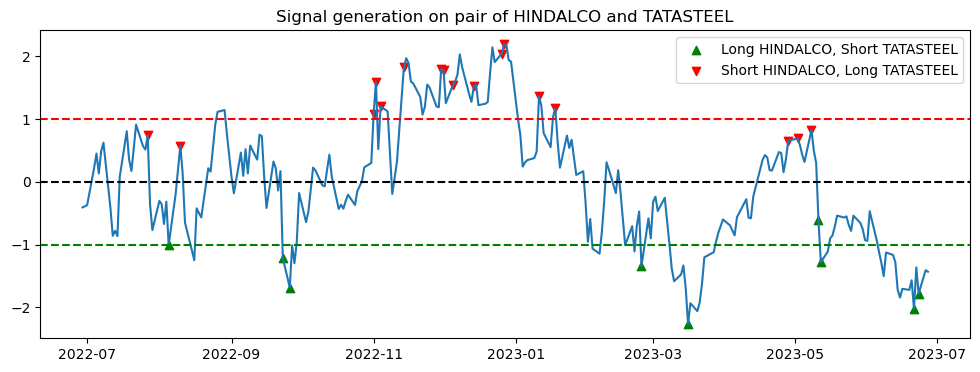

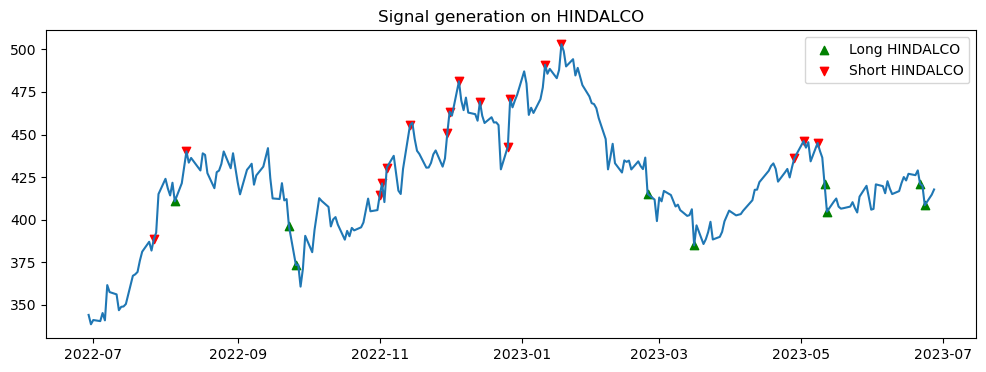

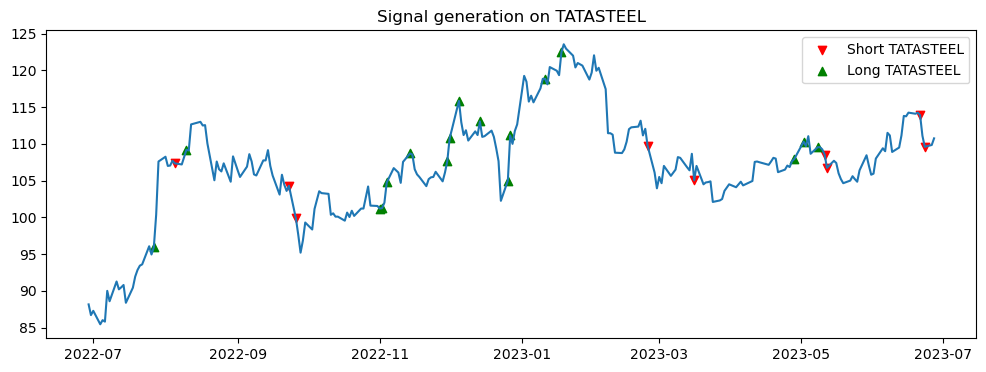

In [10]:
# Plotting the positions of the pair trading strategy
plt.figure(figsize=(12,4))
plt.title("Signal generation on pair of HINDALCO and TATASTEEL")
plt.plot(data.index, data['z-score'])
plt.scatter(data[data['Position'] == 1].index, data[data['Position'] == 1]['z-score'], marker='^', color='g', label='Long HINDALCO, Short TATASTEEL')
plt.scatter(data[data['Position'] == -1].index, data[data['Position'] == -1]['z-score'], marker='v', color='r', label='Short HINDALCO, Long TATASTEEL')
plt.axhline(1, linestyle='dashed', color='red')
plt.axhline(0, linestyle='dashed', color='black')
plt.axhline(-1, linestyle='dashed', color='green')
plt.legend()
plt.figure(figsize=(12,4))
plt.title("Signal generation on HINDALCO")
plt.plot(data.index, data['HINDALCO'])
plt.scatter(data[data['Position'] == 1].index, data[data['Position'] == 1]['HINDALCO'], marker='^', color='g', label='Long HINDALCO')
plt.scatter(data[data['Position'] == -1].index, data[data['Position'] == -1]['HINDALCO'], marker='v', color='r', label='Short HINDALCO')
plt.legend()
plt.figure(figsize=(12,4))
plt.title("Signal generation on TATASTEEL")
plt.plot(data.index, data['TATASTEEL'])
plt.scatter(data[data['Position'] == 1].index, data[data['Position'] == 1]['TATASTEEL'], marker='v', color='r', label='Short TATASTEEL')
plt.scatter(data[data['Position'] == -1].index, data[data['Position'] == -1]['TATASTEEL'], marker='^', color='g', label='Long TATASTEEL')
plt.legend()
plt.show()

Portfolio Value = 123804.20993804932
Cumulative Return = 22.904209938049316 %


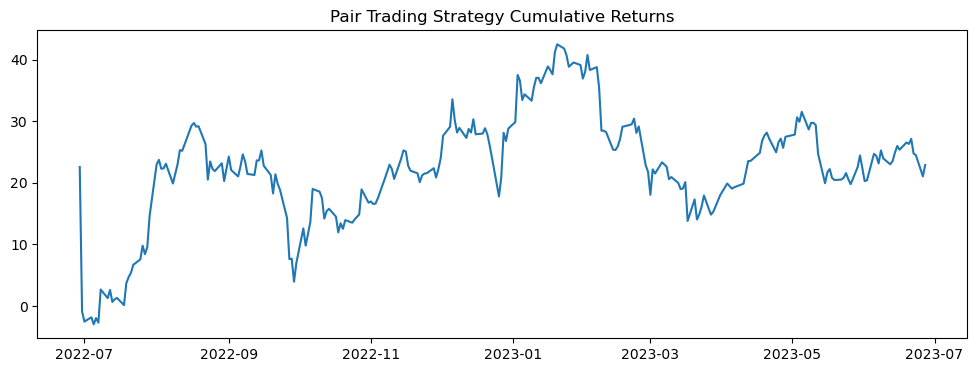

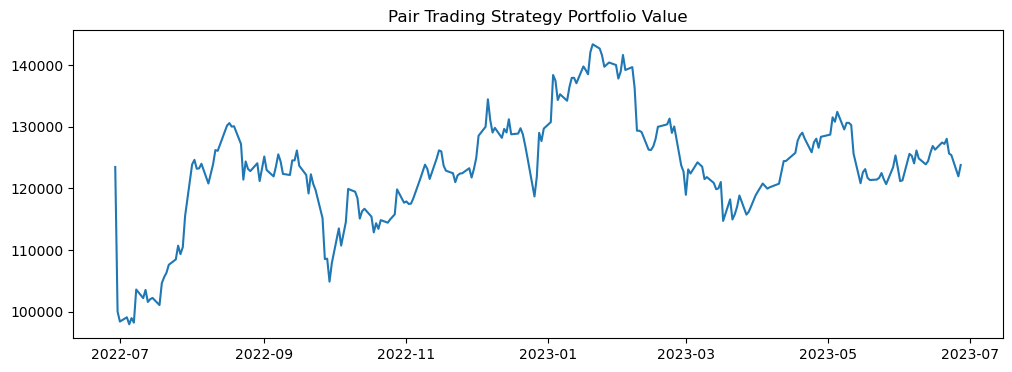

In [11]:
# Calculating portfolio value and cumulative returns 
capital = 100000
trading_cost = 0.001

n1 = (capital // 2) // data['HINDALCO'][0] 
n2 = (capital // 2) // data['TATASTEEL'][0]
capital -= n1 * data['HINDALCO'][0]
capital -= n2 * data['TATASTEEL'][0]

if np.less(data[data['Position'] == -1]['Position'].count(), data[data['Position'] == 1]['Position'].count()):
    Total_Trades = data[data['Position'] == -1]['Position'].count()
else: Total_Trades = data[data['Position'] == 1]['Position'].count()

Current_Value = []
Returns = []

#Iterate over positions
for i in range(0, len(data['Position'])):
    if data['Position'][i] == -1:  # short HINDALCO, long TATASTEEL
        capital += n1 * data['HINDALCO'][i-1]
        n1 = 0
        n2 += capital // data['TATASTEEL'][i-1]
        capital -= (capital // data['TATASTEEL'][i-1]) * data['TATASTEEL'][i-1]
    elif data['Position'][i] == 1:  # long HINDALCO, short TATASTEEL
        capital += n2 * data['TATASTEEL'][i-1]
        n2 = 0
        n1 += capital // data['HINDALCO'][i-1]
        capital -= (capital // data['HINDALCO'][i-1]) * data['HINDALCO'][i-1]

    Current_Value.append((n1 * data['HINDALCO'][i-1] + n2 * data['TATASTEEL'][i-1]) + capital)
    Returns.append((((Current_Value[i] - 100000) / 100000) - (Total_Trades * trading_cost)) * 100)

data['Portfolio_Value'] = Current_Value
data['Cumulative_Returns'] = Returns
Cumulative_Return = data['Cumulative_Returns'][246]

print('Portfolio Value =', data['Portfolio_Value'][246])
print('Cumulative Return =', Cumulative_Return, '%')

# Plotting the pair trading strategy cumulative returns and portfolio value
plt.figure(figsize=(12,4))
plt.plot(data.index, data['Cumulative_Returns'])
plt.title('Pair Trading Strategy Cumulative Returns')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(data.index, data['Portfolio_Value'])
plt.title('Pair Trading Strategy Portfolio Value')
plt.show()

In [12]:
# Calculating sharpe ratio
risk_free_rate = 0.05
Average_Return = data['Cumulative_Returns'].mean()
Volatality = data['Cumulative_Returns'].std()

if Volatality != 0:
    Sharpe_Ratio = (Average_Return - risk_free_rate) / Volatality
else: Sharpe_Ratio = 0

print('Sharpe Ratio =', Sharpe_Ratio)

Sharpe Ratio = 2.4513403546351795


In [13]:
# Calculating maximum drwadown
Peak = np.max(data['Portfolio_Value'])
for i in range(0, len(data['Portfolio_Value'])):
    if data['Portfolio_Value'][i] == Peak:
        Trough = np.min(data['Portfolio_Value'].tail(-i))

Max_Drawdown = (Peak - Trough) / Peak * 100

print('Maximum Drawdown =', Max_Drawdown, '%')

Maximum Drawdown = 20.004571891276665 %


In [14]:
# just for reference
data

,HINDALCO,H_Closing,H_DailyRet,TATASTEEL,T_Closing,T_DailyRet,Spread,Differential,Price_Ratio,z-score,Position,Action,Portfolio_Value,Cumulative_Returns
Date,,,,,,,,,,,,,,
2022-06-29,344.149994,NaN,NaN,88.160004,NaN,NaN,NaN,255.989990,3.903698,-0.405512,0,No action,123480.528809,22.580529
2022-06-30,338.649994,-5.500000,-1.598140,86.705002,-1.455002,-1.650410,-4.044998,251.944992,3.905772,-0.389368,0,No action,100000.000000,-0.900000
2022-07-01,341.149994,2.500000,0.738225,87.285004,0.580002,0.668937,1.919998,253.864990,3.908461,-0.368448,0,No action,98377.513962,-2.522486
2022-07-04,340.500000,-0.649994,-0.190530,85.455002,-1.830002,-2.096582,1.180008,255.044998,3.984553,0.223676,0,No action,99068.875000,-1.831125
2022-07-05,345.250000,4.750000,1.395007,86.014999,0.559998,0.655313,4.190002,259.235001,4.013835,0.451534,0,No action,97937.014847,-2.962985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,420.950012,-8.000000,-1.865019,113.900002,-0.349998,-0.306344,-7.650002,307.050011,3.695786,-2.023403,1,"Long Hindalco, Short TataSteel",128050.709938,27.150710
2023-06-22,420.049988,-0.900024,-0.213808,111.099998,-2.800003,-2.458299,1.899979,308.949989,3.780828,-1.361637,0,No action,125666.709938,24.766710
2023-06-23,408.500000,-11.549988,-2.749670,109.599998,-1.500000,-1.350135,-10.049988,298.900002,3.727190,-1.779029,1,"Long Hindalco, Short TataSteel",125398.502663,24.498503


In [15]:
# Sensitivity Analysis
thresholds = [0.5, 0.7, 1.0, 1.5, 2.5]
lookback_periods = [10, 14, 30, 60]
trading_costs = [0.001, 0.005, 0.01]
risk_free_rates = [0.02, 0.05, 0.1]

# Define target variable and metrics and choose the target variable to optimize
target_variable_1 = 'Portfolio Value'
target_variable_2 = 'Cumulative Return'
target_variable_3 = 'Sharpe Ratio'
target_variable_4 = 'Maximum Drawdown'
best_metric_1 = -float('inf')  # Initialize the best metric value
best_metric_2 = -float('inf')
best_metric_3 = -float('inf')
best_metric_4 = float('inf')
best_parameters = None  # Initialize the best parameter combination

# Iterate over parameter combinations
for entry_threshold, exit_threshold, lookback_period, trading_cost, risk_free_rate in it.product(thresholds, thresholds, lookback_periods, trading_costs, risk_free_rates):
    # Calculate the spread, mean, and standard deviation
    spread_mean = data['Spread'].rolling(window=lookback_period).mean()
    spread_std = data['Spread'].rolling(window=lookback_period).std()
    
    position = np.arange(247)  # 1: long HINDALCO, short TATASTEEL = Buy | -1: short HINDALCO, long TATASTEEL = Sell | 0: no position
    position.fill(0)
    
    for i in range(0, len(data['Spread'])):
        # Check if the spread crosses the entry threshold in the desired direction
        if (data['Spread'][i] < (spread_mean[i] - (entry_threshold * spread_std[i]))) and (data['z-score'][i] < 0) and (position[i] == 0):
            position[i] = 1  # Enter long position: long HINDALCO, short TATASTEEL
        if (data['Spread'][i] > (spread_mean[i] + (exit_threshold * spread_std[i]))) and (data['z-score'][i] > 0) and (position[i] == 0): 
            position[i] = -1 # Enter short position: short HINDALCO, long TATASTEEL

    # Calculating portfolio value and cumulative return
    cap = 100000
    
    N1 = (cap // 2) // data['HINDALCO'][0] 
    N2 = (cap // 2) // data['TATASTEEL'][0]
    cap -= N1 * data['HINDALCO'][0]
    cap -= N2 * data['TATASTEEL'][0]

    if np.less(np.count_nonzero(position == -1), np.count_nonzero(position == 1)):
        trades = np.count_nonzero(position == -1)
    else: trades = np.count_nonzero(position == 1)

    value = []
    returns = []
    
    for i in range(0, len(position)):
        if position[i] == -1:  # short HINDALCO, long TATASTEEL
            cap += N1 * data['HINDALCO'][i-1]
            N1 = 0
            N2 += cap // data['TATASTEEL'][i-1]
            cap -= (cap // data['TATASTEEL'][i-1]) * data['TATASTEEL'][i-1]
        elif position[i] == 1:  # long HINDALCO, short TATASTEEL
            cap += N2 * data['TATASTEEL'][i-1]
            N2 = 0
            N1 += cap // data['HINDALCO'][i-1]
            cap -= (cap // data['HINDALCO'][i-1]) * data['HINDALCO'][i-1]

        value.append((N1 * data['HINDALCO'][i-1] + N2 * data['TATASTEEL'][i-1]) + cap)
        returns.append((((value[i] - 100000) / 100000) - (trades * trading_cost)) * 100)

        portfolio_value = value[-1]
        cumulative_return = returns[-1]

    # Calculating sharpe ratio
    avg_return = np.mean(returns)
    volatality = np.std(returns)

    if volatality != 0:
        sharpe_ratio = (avg_return - risk_free_rate) / volatality
    else: sharpe_ratio = 0

    # Calculating maximum drwadown
    df = pd.Series(value)
    peak = np.max(df)
    for i in range(0, len(df)):
        if df[i] == peak:
            trough = np.min(df.tail(-i))

    maximum_drawdown = (peak - trough) / peak * 100

    # Check if the current metric value is better than the previous best value
    if portfolio_value > best_metric_1:
        best_metric_1 = portfolio_value
        best_parameters = (entry_threshold, exit_threshold, lookback_period, trading_cost, risk_free_rate)
    if cumulative_return > best_metric_2:
        best_metric_2 = cumulative_return
        best_parameters = (entry_threshold, exit_threshold, lookback_period, trading_cost, risk_free_rate)
    if sharpe_ratio > best_metric_3:
        best_metric_3 = sharpe_ratio
        best_parameters = (entry_threshold, exit_threshold, lookback_period, trading_cost, risk_free_rate)
    if maximum_drawdown < best_metric_4:
        best_metric_4 = maximum_drawdown
        best_parameters = (entry_threshold, exit_threshold, lookback_period, trading_cost, risk_free_rate)
    
    # Printing parameters and their repsective metrics
    print('Parameters:')
    print('Entry_Threshold =', entry_threshold)
    print('Exit_Threshold =', exit_threshold)
    print('Lookback Period =', lookback_period)
    print('Trading Cost =', trading_cost)
    print('Risk Free Rate =', risk_free_rate)
    print('Metrics:')
    print(target_variable_1, '=', portfolio_value)
    print(target_variable_2, '=', cumulative_return, '%')
    print(target_variable_3, '=', sharpe_ratio)
    print(target_variable_4, '=', maximum_drawdown, '%')
    print('')

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 10
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 114527.41246032715
Cumulative Return = 10.82741246032715 %
Sharpe Ratio = 1.897664519586169
Maximum Drawdown = 18.588961245477012 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 10
Trading Cost = 0.001
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 114527.41246032715
Cumulative Return = 10.82741246032715 %
Sharpe Ratio = 1.893223182211235
Maximum Drawdown = 18.588961245477012 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 10
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 114527.41246032715
Cumulative Return = 10.82741246032715 %
Sharpe Ratio = 1.8858209532530124
Maximum Drawdown = 18.588961245477012 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 10
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 114527.4124603271

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 60
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 112996.0772781372
Cumulative Return = -0.003922721862792411 %
Sharpe Ratio = 0.5918814388304005
Maximum Drawdown = 21.902300029878482 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 60
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 112996.0772781372
Cumulative Return = -0.003922721862792411 %
Sharpe Ratio = 0.5852881528100989
Maximum Drawdown = 21.902300029878482 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 60
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 112996.0772781372
Cumulative Return = -13.003922721862793 %
Sharpe Ratio = -1.1184169548358316
Maximum Drawdown = 21.902300029878482 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.5
Lookback Period = 60
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 112996.07

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.7
Lookback Period = 60
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 112996.0772781372
Cumulative Return = 0.9960772781372085 %
Sharpe Ratio = 0.7237471592364324
Maximum Drawdown = 21.902300029878482 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.7
Lookback Period = 60
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 112996.0772781372
Cumulative Return = 0.9960772781372085 %
Sharpe Ratio = 0.7171538732161308
Maximum Drawdown = 21.902300029878482 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.7
Lookback Period = 60
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 112996.0772781372
Cumulative Return = -11.003922721862791 %
Sharpe Ratio = -0.8546855140237678
Maximum Drawdown = 21.902300029878482 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 0.7
Lookback Period = 60
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 112996.07727813

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.0
Lookback Period = 60
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 111523.17737579346
Cumulative Return = 9.823177375793456 %
Sharpe Ratio = 1.9506440610116922
Maximum Drawdown = 22.9171984201881 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.0
Lookback Period = 60
Trading Cost = 0.001
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 111523.17737579346
Cumulative Return = 9.823177375793456 %
Sharpe Ratio = 1.94681901071637
Maximum Drawdown = 22.9171984201881 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.0
Lookback Period = 60
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 111523.17737579346
Cumulative Return = 9.823177375793456 %
Sharpe Ratio = 1.9404439268908338
Maximum Drawdown = 22.9171984201881 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.0
Lookback Period = 60
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 111523.17737579346
Cumu

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 117763.91396331787
Cumulative Return = 12.763913963317869 %
Sharpe Ratio = 1.8388165576470403
Maximum Drawdown = 21.621902610875743 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 117763.91396331787
Cumulative Return = 12.763913963317869 %
Sharpe Ratio = 1.8350965077025607
Maximum Drawdown = 21.621902610875743 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 117763.91396331787
Cumulative Return = 12.763913963317869 %
Sharpe Ratio = 1.8288964244617614
Maximum Drawdown = 21.621902610875743 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 1.5
Lookback Period = 60
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 118857.46376800

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 120969.28322601318
Cumulative Return = 20.969283226013182 %
Sharpe Ratio = 2.362801360300599
Maximum Drawdown = 23.414928210128107 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 120969.28322601318
Cumulative Return = 20.969283226013182 %
Sharpe Ratio = 2.3709860421692075
Maximum Drawdown = 23.414928210128107 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 120969.28322601318
Cumulative Return = 20.969283226013182 %
Sharpe Ratio = 2.367916786468479
Maximum Drawdown = 23.414928210128107 %

Parameters:
Entry_Threshold = 0.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 120969.28322601318

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 117543.81871795654
Cumulative Return = 4.543818717956544 %
Sharpe Ratio = 0.8245933209699918
Maximum Drawdown = 17.945423768537992 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 117543.81871795654
Cumulative Return = 4.543818717956544 %
Sharpe Ratio = 0.817680352285973
Maximum Drawdown = 17.945423768537992 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 117543.81871795654
Cumulative Return = -8.456181282043456 %
Sharpe Ratio = -0.9686307556645026
Maximum Drawdown = 17.945423768537992 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 117543.818717956

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 116995.22408294678
Cumulative Return = 14.495224082946779 %
Sharpe Ratio = 2.2233678887252633
Maximum Drawdown = 17.961905778707937 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 116995.22408294678
Cumulative Return = 4.495224082946778 %
Sharpe Ratio = 0.8460457865926674
Maximum Drawdown = 17.961905778707937 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 116995.22408294678
Cumulative Return = 4.495224082946778 %
Sharpe Ratio = 0.841880497977347
Maximum Drawdown = 17.961905778707937 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 116995.224082946

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 116577.72411346436
Cumulative Return = 14.777724113464357 %
Sharpe Ratio = 2.2896021520235466
Maximum Drawdown = 17.962802101437603 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 116577.72411346436
Cumulative Return = 7.577724113464357 %
Sharpe Ratio = 1.2947619286935248
Maximum Drawdown = 17.962802101437603 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 116577.72411346436
Cumulative Return = 7.577724113464357 %
Sharpe Ratio = 1.2905701861794938
Maximum Drawdown = 17.962802101437603 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 116577.72411346

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 122625.21569824219
Cumulative Return = 22.125215698242187 %
Sharpe Ratio = 2.5757600161115053
Maximum Drawdown = 18.392808948232464 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 122625.21569824219
Cumulative Return = 22.125215698242187 %
Sharpe Ratio = 2.569698362544134
Maximum Drawdown = 18.392808948232464 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 122625.21569824219
Cumulative Return = 20.125215698242187 %
Sharpe Ratio = 2.3369308655570857
Maximum Drawdown = 18.392808948232464 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 122625.215698

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 2.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 120272.28234863281
Cumulative Return = 20.27228234863281 %
Sharpe Ratio = 2.3327912082011673
Maximum Drawdown = 23.460083680932968 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 120969.28322601318
Cumulative Return = 20.969283226013182 %
Sharpe Ratio = 2.3709860421692075
Maximum Drawdown = 23.414928210128107 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 120969.28322601318
Cumulative Return = 20.969283226013182 %
Sharpe Ratio = 2.367916786468479
Maximum Drawdown = 23.414928210128107 %

Parameters:
Entry_Threshold = 0.7
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 120969.283226013

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 119217.46308135986
Cumulative Return = 1.2174630813598653 %
Sharpe Ratio = 0.33848251713911987
Maximum Drawdown = 17.93975804496822 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 119217.46308135986
Cumulative Return = 1.2174630813598653 %
Sharpe Ratio = 0.33195986624726503
Maximum Drawdown = 17.93975804496822 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 118858.37405395508
Cumulative Return = 17.15837405395508 %
Sharpe Ratio = 2.4625023873273926
Maximum Drawdown = 17.948703253307993 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 118858.37405395

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 119884.4737701416
Cumulative Return = 10.8844737701416 %
Sharpe Ratio = 1.5692866443545075
Maximum Drawdown = 17.958358375856555 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 119884.4737701416
Cumulative Return = 10.8844737701416 %
Sharpe Ratio = 1.5628745674685018
Maximum Drawdown = 17.958358375856555 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 119884.4737701416
Cumulative Return = 1.884473770141601 %
Sharpe Ratio = 0.418960051005083
Maximum Drawdown = 17.958358375856555 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 119884.4737701416
Cumul

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 116775.47480010986
Cumulative Return = 7.775474800109864 %
Sharpe Ratio = 1.3119032079213935
Maximum Drawdown = 17.94015090718413 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 116775.47480010986
Cumulative Return = 7.775474800109864 %
Sharpe Ratio = 1.3050111422194364
Maximum Drawdown = 17.94015090718413 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 116775.47480010986
Cumulative Return = -1.2245251998901363 %
Sharpe Ratio = 0.07546662099023374
Maximum Drawdown = 17.94015090718413 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 116775.4748001098

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 122023.32512664795
Cumulative Return = 21.023325126647947 %
Sharpe Ratio = 2.5387205435121563
Maximum Drawdown = 17.961572559921667 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 122023.32512664795
Cumulative Return = 17.023325126647947 %
Sharpe Ratio = 2.044714579959983
Maximum Drawdown = 17.961572559921667 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 122023.32512664795
Cumulative Return = 17.023325126647947 %
Sharpe Ratio = 2.0409339220756553
Maximum Drawdown = 17.961572559921667 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 122023.3251266

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 2.5
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 120272.28234863281
Cumulative Return = 20.27228234863281 %
Sharpe Ratio = 2.3327912082011673
Maximum Drawdown = 23.460083680932968 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 2.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 120272.28234863281
Cumulative Return = 20.27228234863281 %
Sharpe Ratio = 2.341093644308476
Maximum Drawdown = 23.460083680932968 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 2.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 120272.28234863281
Cumulative Return = 20.27228234863281 %
Sharpe Ratio = 2.3379802307682356
Maximum Drawdown = 23.460083680932968 %

Parameters:
Entry_Threshold = 1.0
Exit_Threshold = 2.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 120272.28234863281
C

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.5
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 113940.25296020508
Cumulative Return = 8.940252960205077 %
Sharpe Ratio = 1.6656628291842206
Maximum Drawdown = 19.98407403427751 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 113940.25296020508
Cumulative Return = 3.9402529602050764 %
Sharpe Ratio = 0.9966980004040911
Maximum Drawdown = 19.98407403427751 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 113940.25296020508
Cumulative Return = 3.9402529602050764 %
Sharpe Ratio = 0.9926189465700658
Maximum Drawdown = 19.98407403427751 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 113940.25296020508
C

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 114540.16358184814
Cumulative Return = 9.540163581848145 %
Sharpe Ratio = 1.7206114686007274
Maximum Drawdown = 20.003280021479952 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 114540.16358184814
Cumulative Return = 4.5401635818481445 %
Sharpe Ratio = 1.0618143044482369
Maximum Drawdown = 20.003280021479952 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 114540.16358184814
Cumulative Return = 4.5401635818481445 %
Sharpe Ratio = 1.0577972485692582
Maximum Drawdown = 20.003280021479952 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 114540.1635818481

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 113001.46641540527
Cumulative Return = 8.001466415405273 %
Sharpe Ratio = 1.5997481372515285
Maximum Drawdown = 19.99388757337518 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 113001.46641540527
Cumulative Return = 8.001466415405273 %
Sharpe Ratio = 1.5927492293191947
Maximum Drawdown = 19.99388757337518 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 113001.46641540527
Cumulative Return = 3.001466415405274 %
Sharpe Ratio = 0.9040566887775325
Maximum Drawdown = 19.99388757337518 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.0
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 113001.46641540527
C

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 117187.8683013916
Cumulative Return = 7.1878683013916005 %
Sharpe Ratio = 1.1291225191426721
Maximum Drawdown = 19.992646363576903 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 117187.8683013916
Cumulative Return = 7.1878683013916005 %
Sharpe Ratio = 1.125096840698679
Maximum Drawdown = 19.992646363576903 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.5
Lookback Period = 14
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 117187.8683013916
Cumulative Return = 7.1878683013916005 %
Sharpe Ratio = 1.1183873766253578
Maximum Drawdown = 19.992646363576903 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 116445.06497955322


Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 119353.43058013916
Cumulative Return = 19.35343058013916 %
Sharpe Ratio = 2.300613029535775
Maximum Drawdown = 23.407329041831783 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 119353.43058013916
Cumulative Return = 19.35343058013916 %
Sharpe Ratio = 2.309119389633512
Maximum Drawdown = 23.407329041831783 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 119353.43058013916
Cumulative Return = 19.35343058013916 %
Sharpe Ratio = 2.3059295045968606
Maximum Drawdown = 23.407329041831783 %

Parameters:
Entry_Threshold = 1.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 119353.43058013916

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.001
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 118945.87704467773
Cumulative Return = 18.845877044677735 %
Sharpe Ratio = 2.587488198514607
Maximum Drawdown = 18.074557423718698 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 118945.87704467773
Cumulative Return = 18.445877044677733 %
Sharpe Ratio = 2.5487429218024196
Maximum Drawdown = 18.074557423718698 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 118945.87704467773
Cumulative Return = 18.445877044677733 %
Sharpe Ratio = 2.545110552110652
Maximum Drawdown = 18.074557423718698 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 118945.87704467

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 118181.02792358398
Cumulative Return = 17.681027923583983 %
Sharpe Ratio = 2.5158947674772976
Maximum Drawdown = 18.074342760570588 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 118181.02792358398
Cumulative Return = 17.681027923583983 %
Sharpe Ratio = 2.509726783594201
Maximum Drawdown = 18.074342760570588 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 118181.02792358398
Cumulative Return = 17.181027923583983 %
Sharpe Ratio = 2.4579157189761944
Maximum Drawdown = 18.074342760570588 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.7
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 118181.02792358

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 118181.02792358398
Cumulative Return = 17.181027923583983 %
Sharpe Ratio = 2.4579157189761944
Maximum Drawdown = 18.074342760570588 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 118181.02792358398
Cumulative Return = 17.181027923583983 %
Sharpe Ratio = 2.4542149286463366
Maximum Drawdown = 18.074342760570588 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.0
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 118181.02792358398
Cumulative Return = 17.181027923583983 %
Sharpe Ratio = 2.4480469447632403
Maximum Drawdown = 18.074342760570588 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.0
Lookback Period = 60
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 124449.22444915

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 117614.77617645264
Cumulative Return = 17.114776176452636 %
Sharpe Ratio = 2.4849881480068796
Maximum Drawdown = 18.077047300583978 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.005
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 117614.77617645264
Cumulative Return = 17.114776176452636 %
Sharpe Ratio = 2.4787691513875463
Maximum Drawdown = 18.077047300583978 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 117614.77617645264
Cumulative Return = 16.614776176452636 %
Sharpe Ratio = 2.426529579785146
Maximum Drawdown = 18.077047300583978 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 1.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 117614.77617645

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 119099.28057861328
Cumulative Return = 19.099280578613282 %
Sharpe Ratio = 2.48485925312375
Maximum Drawdown = 19.778026313180085 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.05
Metrics:
Portfolio Value = 119099.28057861328
Cumulative Return = 19.099280578613282 %
Sharpe Ratio = 2.48141054463478
Maximum Drawdown = 19.778026313180085 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 2.5
Lookback Period = 30
Trading Cost = 0.01
Risk Free Rate = 0.1
Metrics:
Portfolio Value = 119099.28057861328
Cumulative Return = 19.099280578613282 %
Sharpe Ratio = 2.4756626971531626
Maximum Drawdown = 19.778026313180085 %

Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 2.5
Lookback Period = 60
Trading Cost = 0.001
Risk Free Rate = 0.02
Metrics:
Portfolio Value = 126058.72617340088


In [16]:
# Print the best parameter combination and the corresponding best metric value
print('Best Parameters:')
print('Entry_Threshold =', best_parameters[0])
print('Exit_Threshold =', best_parameters[1])
print('Lookback Period =', best_parameters[2])
print('Trading Cost =', best_parameters[3])
print('Risk Free Rate =', best_parameters[4])
print('')
print('Best Metrics:')
print('Best', target_variable_1, '=', best_metric_1)
print('Best', target_variable_2, '=', best_metric_2, '%')
print('Best', target_variable_3, '=', best_metric_3)
print('Best', target_variable_4, '=', best_metric_4, '%')

Best Parameters:
Entry_Threshold = 2.5
Exit_Threshold = 0.7
Lookback Period = 14
Trading Cost = 0.001
Risk Free Rate = 0.02

Best Metrics:
Best Portfolio Value = 127777.58168029785
Best Cumulative Return = 27.677581680297852 %
Best Sharpe Ratio = 2.7042434008195917
Best Maximum Drawdown = 17.349111474591002 %
